In [1]:
!pip install pyspark
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=b87886902ab3394c106b428fae07765a8fca6abd813e6add0bc75123d7dfedcb
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publi

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import stddev,countDistinct,count,avg,col
from pyspark.sql.functions import when
from pyspark.sql.functions import mean

from pyspark.sql.types import IntegerType
from sklearn.impute import SimpleImputer

In [4]:
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [5]:
data_as_spark = spark.read.csv('logistic_regresion_data.csv',header=True)

In [6]:
data_as_spark.columns

['Numar',
 'Stare',
 'Hipertensiv',
 'Fibrilatie_atriala',
 'Anemii_deficitare',
 'Depresie',
 'Insuficienta_renala',
 'Frecventa_respiratorie',
 'Latimea_distributiei_globulelor_rosii',
 'Leucocite',
 'Timp_de_protrombina',
 'Raport_internationalizat_normalizat',
 'NT_proBNP',
 'Nitrogen_ureic',
 'Potasiu_din_sange',
 'Interval_anionic',
 'Acid_lactic']

In [ ]:
col = ['Stare','Varsta','Sex','Indice_de_masa_corporala','Hipertensiv','Fibrilatie_atriala','Boala_coronariana','Diabet','Anemii_deficitare','Depresie','Hiperlipemie','Insuficienta_renala','Boala_pulmonara_obstructiva_cronica','Frecventa_cardiaca','Tensiune_arteriala_sistolica','Tensiune_arteriala_diastolica','Frecventa_respiratorie','Temperatura','Saturatia_pulsului_de_oxigen','Urina','Volumul_celule_rosii_din_sange','Globule_rosii','Hemoglobina_corpusculara_medie','Concentratia_medie_a_hemoglobinei_corpusculare','Volumul_corpuscular_mediu','Latimea_distributiei_globulelor_rosii','Leucocite','Trombocite','Neurofile','Globule_albe','Limfocite','Timp_de_protrombina','Raport_internationalizat_normalizat','NT_proBNP','Creatin_kinaza','Creatina','Nitrogen_ureic','Glucoza','Potasiu_din_sange','Sodiu_din_sange','Calciu_din_sange','Clorura','Interval_anionic','Ioni_de_magneziu','Concentratia_ionilor_de_oxigen','Bicarbote','Acid_lactic','Presiunea_partiala_a_dioxidului_de_carbon','Fractie_de_eliminare']


dataframe = data_as_csv

# ----------------Target Column-------------------------------------------------
dataframe['Stare'] = dataframe['Stare'].replace({'alive': 0, 'dead': 1})
# --------------------Categorical Columns---------------------------------------
dataframe['Hipertensiv'] = dataframe['Hipertensiv'].replace({'nu': 0,'da': 1})
dataframe['Fibrilatie_atriala'] = dataframe['Fibrilatie_atriala'].replace({'nu': 0,'da': 1})
dataframe['Boala_coronariana'] = dataframe['Boala_coronariana'].replace({'nu': 0,'da': 1})
dataframe['Anemii_deficitare'] = dataframe['Anemii_deficitare'].replace({'nu': 0,'da': 1})
dataframe['Depresie'] = dataframe['Depresie'].replace({'nu': 0,'da': 1})
dataframe['Hiperlipemie'] = dataframe['Hiperlipemie'].replace({'nu': 0,'da': 1})
dataframe['Insuficienta_renala'] = dataframe['Insuficienta_renala'].replace({'nu': 0,'da': 1})
dataframe['Boala_pulmonara_obstructiva_cronica'] = dataframe['Boala_pulmonara_obstructiva_cronica'].replace({'nu': 0,'da': 1})


In [7]:
# Salvam datele intr-o alta variabila
log_regr_data = data_as_spark.select("Stare",
                                     "Hipertensiv",
                                     "Fibrilatie_atriala",
                                     "Anemii_deficitare",
                                     "Depresie",
                                     "Insuficienta_renala",
                                     data_as_spark.Frecventa_respiratorie.cast("float"),
                                     data_as_spark.Latimea_distributiei_globulelor_rosii.cast("float"),
                                     data_as_spark.Leucocite.cast("float"),
                                     data_as_spark.Timp_de_protrombina.cast("float"),
                                     data_as_spark.Raport_internationalizat_normalizat.cast("float"),
                                     data_as_spark.NT_proBNP.cast("float"),
                                     data_as_spark.Nitrogen_ureic.cast("float"),
                                     data_as_spark.Potasiu_din_sange.cast("float"),
                                     data_as_spark.Interval_anionic.cast("float"),
                                     data_as_spark.Acid_lactic.cast("float"))
cols = log_regr_data.columns

#1 Modificarea coloanei Stare
log_regr_data = log_regr_data.withColumn("Stare",when(log_regr_data.Stare == "alive","yes").when(log_regr_data.Stare == "dead","no").otherwise("null"))
#2 Modificarea coloanei Hipertensiv
log_regr_data = log_regr_data.withColumn("Hipertensiv",when(log_regr_data.Hipertensiv == "nu","no").when(log_regr_data.Hipertensiv == "da","yes").otherwise("null"))
#3 Modificarea coloanei Fibrilatie_atriala
log_regr_data = log_regr_data.withColumn("Fibrilatie_atriala",when(log_regr_data.Fibrilatie_atriala == "nu","no").when(log_regr_data.Fibrilatie_atriala == "da","yes").otherwise("null"))
#4 Modificarea coloanei Anemii_deficitare
log_regr_data = log_regr_data.withColumn("Anemii_deficitare",when(log_regr_data.Anemii_deficitare == "nu","no").when(log_regr_data.Anemii_deficitare == "da","yes").otherwise("null"))
#5 Modificarea coloanei Depresie
log_regr_data = log_regr_data.withColumn("Depresie",when(log_regr_data.Depresie == "nu","no").when(log_regr_data.Depresie == "da","yes").otherwise("null"))
#6 Modificarea coloanei Insuficienta_renala
log_regr_data = log_regr_data.withColumn("Insuficienta_renala",when(log_regr_data.Insuficienta_renala == "nu","no").when(log_regr_data.Insuficienta_renala == "da","yes").otherwise("null"))

# Afisarea datelor finale
log_regr_data.select("Stare","Hipertensiv","Fibrilatie_atriala","Anemii_deficitare","Depresie","Insuficienta_renala").show()
log_regr_data.select("Frecventa_respiratorie","Latimea_distributiei_globulelor_rosii","Leucocite","Timp_de_protrombina","Raport_internationalizat_normalizat").show()
log_regr_data.select("NT_proBNP","Nitrogen_ureic","Potasiu_din_sange","Interval_anionic","Acid_lactic").show()
log_regr_data.count()
log_regr_data.printSchema()

+-----+-----------+------------------+-----------------+--------+-------------------+
|Stare|Hipertensiv|Fibrilatie_atriala|Anemii_deficitare|Depresie|Insuficienta_renala|
+-----+-----------+------------------+-----------------+--------+-------------------+
|  yes|         no|                no|              yes|      no|                yes|
|  yes|         no|                no|              yes|      no|                 no|
|  yes|         no|                no|              yes|      no|                yes|
|  yes|         no|                no|               no|      no|                 no|
|  yes|        yes|                no|              yes|      no|                yes|
|  yes|        yes|               yes|              yes|      no|                yes|
|  yes|        yes|                no|               no|      no|                yes|
|  yes|        yes|               yes|              yes|      no|                 no|
|  yes|        yes|               yes|               n

In [8]:
from pyspark.ml.feature import OneHotEncoder,StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

In [9]:
categoricalColumns = ['Hipertensiv','Fibrilatie_atriala','Anemii_deficitare','Depresie','Insuficienta_renala']
stages = []

In [10]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer,encoder]

In [11]:
label_stringIdx = StringIndexer(inputCol = 'Stare', outputCol = 'label')
stages += [label_stringIdx]

In [12]:
numericCols = ['Frecventa_respiratorie','Latimea_distributiei_globulelor_rosii','Leucocite','Timp_de_protrombina','Raport_internationalizat_normalizat','NT_proBNP','Nitrogen_ureic','Potasiu_din_sange','Interval_anionic','Acid_lactic']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [13]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(log_regr_data)
log_regr_data = pipelineModel.transform(log_regr_data)
selectedCols = ['label', 'features'] + cols
log_regr_data = log_regr_data.select(selectedCols)

In [47]:
train, test = log_regr_data.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 5627
Test Dataset Count: 2605


In [48]:
from pyspark.ml.classification import LogisticRegression

In [158]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30,regParam=0.01,elasticNetParam=0,threshold=0.5,standardization=False)

In [159]:
lrModel = lr.fit(train)

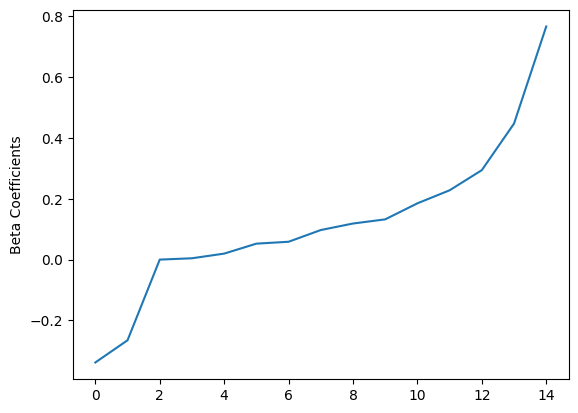

In [160]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

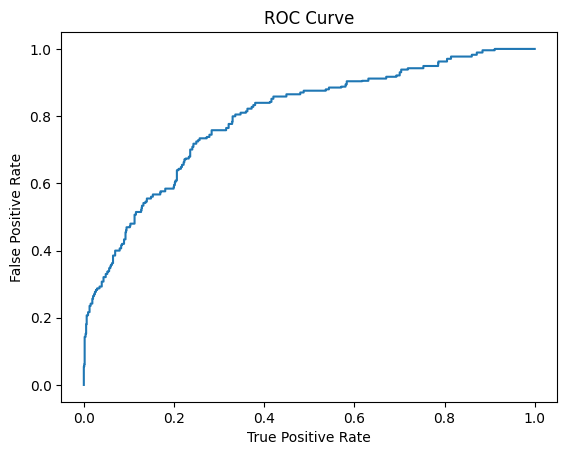

Training set areaUnderROC: 0.7965325037018832


In [161]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

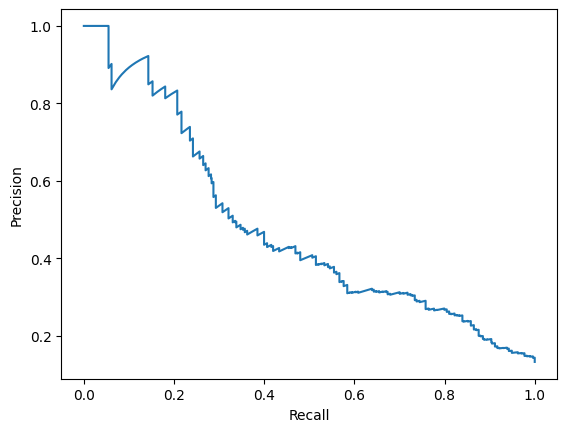

In [162]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [163]:
predictions = lrModel.transform(test)
predictions.select('Fibrilatie_atriala','Depresie','Interval_anionic','Nitrogen_ureic', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------------------+--------+----------------+--------------+-----+--------------------+----------+--------------------+
|Fibrilatie_atriala|Depresie|Interval_anionic|Nitrogen_ureic|label|       rawPrediction|prediction|         probability|
+------------------+--------+----------------+--------------+-----+--------------------+----------+--------------------+
|               yes|     yes|       10.333333|     10.666667|  0.0|[3.08406291013491...|       0.0|[0.95623054792865...|
|               yes|     yes|       10.333333|     10.666667|  0.0|[3.08406291013491...|       0.0|[0.95623054792865...|
|               yes|     yes|       13.666667|     23.333334|  0.0|[1.67538801267425...|       0.0|[0.84229286172193...|
|               yes|      no|       15.909091|     110.72727|  0.0|[0.32817767779635...|       0.0|[0.58131591182811...|
|               yes|      no|          22.375|         117.0|  0.0|[0.33349661521095...|       0.0|[0.58260991316674...|
|               yes|      no|   

In [164]:
predictionAndLabels = lrModel.evaluate(train)
evaluator = BinaryClassificationEvaluator()
predictionAndLabels.predictions.show()

+-----+--------------------+-----+-----------+------------------+-----------------+--------+-------------------+----------------------+-------------------------------------+---------+-------------------+-----------------------------------+---------+--------------+-----------------+----------------+-----------+--------------------+--------------------+----------+
|label|            features|Stare|Hipertensiv|Fibrilatie_atriala|Anemii_deficitare|Depresie|Insuficienta_renala|Frecventa_respiratorie|Latimea_distributiei_globulelor_rosii|Leucocite|Timp_de_protrombina|Raport_internationalizat_normalizat|NT_proBNP|Nitrogen_ureic|Potasiu_din_sange|Interval_anionic|Acid_lactic|       rawPrediction|         probability|prediction|
+-----+--------------------+-----+-----------+------------------+-----------------+--------+-------------------+----------------------+-------------------------------------+---------+-------------------+-----------------------------------+---------+--------------+------

In [165]:
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7812671232876713


In [167]:
# Pentru multiclass
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label',metricName='accuracy')
acc = evaluator.evaluate(predictionAndLabels.predictions)
print(" Accuracy: ", acc)

 Accuracy:  0.8873289497067709
